Using the cms_synthetic_claims.db from https://github.com/theradler/Hackathon25/tree/main/cms_synthetic_claims. Change the path to be your path

In [1]:
# Get the data and take a look at it
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('./cms_synthetic_claims/cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [2]:
# Thats a lot of data, just take a subset of the columns

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_TOT_CHRG_AMT', # claim total charge amount
]

# we need claim data, but we want to add that a specific way

# what to do about 1 bene having multiple claims?

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

# Add a new column for the number of days between CLM_FROM_DT and CLM_THRU_DT
# df_inpatient_subset['CLM_NUM_DAYS'] = (
#     pd.to_datetime(df_inpatient_subset['CLM_THRU_DT']) - pd.to_datetime(df_inpatient_subset['CLM_FROM_DT'])
# ).dt.days



In [3]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT
0,-10000010254618,-10000930037831,96.65
1,-10000010254653,-10000930038030,6311.88
2,-10000010254653,-10000930038031,8545.72
3,-10000010254656,-10000930038162,1014.85
4,-10000010254656,-10000930038162,1014.85
...,...,...,...
58061,-10000010288008,-10000931485965,166.97
58062,-10000010288008,-10000931485967,166.97
58063,-10000010288008,-10000931485969,166.97
58064,-10000010288008,-10000931485971,166.97


In [4]:
# add the diagnosis codes
# Add all ICD_DGNS_CD1-25 and CLM_POA_IND_SW1-25 columns from df_inpatient_claims to df_inpatient_subset

# IGNORE POA FOR NOW, MAYBE LATER

# Identify the columns to add
diagnosis_cols = [f'ICD_DGNS_CD{i}' for i in range(1, 26)]
# poa_cols = [f'CLM_POA_IND_SW{i}' for i in range(1, 26)]

# Only keep columns that exist in df_inpatient_claims
diagnosis_cols = [col for col in diagnosis_cols if col in df_inpatient_claims.columns]
# poa_cols = [col for col in poa_cols if col in df_inpatient_claims.columns]

# Add the principal diagnosis code column
df_inpatient_subset['PRNCPAL_DGNS_CD'] = df_inpatient_claims['PRNCPAL_DGNS_CD'].values

# Create a new column that concatenates all diagnosis codes for each claim into a single string
# df_inpatient_subset['ALL_DGNS_CODES'] = df_inpatient_claims[diagnosis_cols].astype(str).agg('|'.join, axis=1)

# Add these columns to the subset DataFrame
df_inpatient_subset = pd.concat(
    # [df_inpatient_subset, df_inpatient_claims[diagnosis_cols + poa_cols].reset_index(drop=True)],
    # axis=1
    [df_inpatient_subset, df_inpatient_claims[diagnosis_cols].reset_index(drop=True)],
    axis=1
)

In [5]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_DGNS_CD16,ICD_DGNS_CD17,ICD_DGNS_CD18,ICD_DGNS_CD19,ICD_DGNS_CD20,ICD_DGNS_CD21,ICD_DGNS_CD22,ICD_DGNS_CD23,ICD_DGNS_CD24,ICD_DGNS_CD25
0,-10000010254618,-10000930037831,96.65,S134XX,S134XX,R4689,E781,J329,E119,D649,...,None,None,None,None,None,None,None,None,None,None
1,-10000010254653,-10000930038030,6311.88,Z3480,T7432X,E669,C50919,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,-10000010254653,-10000930038031,8545.72,T7432X,T7432X,E669,C50929,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,-10000010254656,-10000930038162,1014.85,S8290X,S8290X,G40909,R569,Z8669,None,None,...,None,None,None,None,None,None,None,None,None,None
4,-10000010254656,-10000930038162,1014.85,S8290X,S8290X,G40909,R569,Z8669,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,-10000010288008,-10000931485965,166.97,T50901A,T7432X,T50901A,J329,R931,I259,G43719,...,None,None,None,None,None,None,None,None,None,None
58062,-10000010288008,-10000931485967,166.97,T50901A,Z733,F0280,T50901A,J329,R931,I259,...,None,None,None,None,None,None,None,None,None,None
58063,-10000010288008,-10000931485969,166.97,T50901A,Z608,Z733,G309,T50901A,J329,R931,...,None,None,None,None,None,None,None,None,None,None
58064,-10000010288008,-10000931485971,166.97,T50901A,Z608,Z733,F0280,T50901A,J329,R931,...,None,None,None,None,None,None,None,None,None,None


In [6]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_inpatient_subset, test_size=0.2, random_state=42)

In [28]:
# Exclude any rows with CLM_TOT_CHRG_AMT > 100000 from train_df before encoding and modeling
train_df = train_df[train_df['CLM_TOT_CHRG_AMT'] <= 100000].copy()

In [29]:
train_df
# test_df

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_TOT_CHRG_AMT_RF_PRED,CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE
54803,-10000010285265,-10000931382342,1946.03,T7431X,T7431X,J209,E785,R931,Z733,I259,...,12037.217370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1946.0300,0.201057
54500,-10000010285023,-10000931374850,16170.16,S2239X,S2239X,N181,E1121,G53,E781,E8881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16057.6627,0.176115
36612,-10000010274658,-10000930936103,1076.76,Z733,Z733,T7432X,Z951,Z608,R931,I259,...,14988.658171,12037.217370,16475.012672,14973.432427,16354.924216,7473.626889,19294.807352,NaN,1076.7600,0.201057
29173,-10000010270941,-10000930756789,165.00,T50901A,Z733,Z608,R931,I259,E1143,Z653,...,14988.658171,8867.217352,16475.012672,14973.432427,12037.217370,7473.626889,NaN,NaN,154.0710,0.200336
6186,-10000010257787,-10000930166772,1732.63,Z608,Z608,Z733,Z604,M7918,M542,E1022,...,8214.087499,14988.658171,10911.882838,16354.924216,19294.807352,13998.824867,14063.573664,NaN,1718.1178,0.198522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-10000010284878,-10000931368856,2222.88,Z604,Z604,Z608,Z733,N1830,R809,Z653,...,14973.432427,11368.787803,5206.088112,14988.658171,6715.505863,16354.924216,6532.699963,16475.012672,2222.8800,0.201057
38158,-10000010275202,-10000930959314,1367.55,Z608,Z608,T7432X,Z733,N1830,R801,N182,...,12037.217370,11483.743330,20459.882213,12448.101568,12336.123636,8144.356186,14988.658171,14509.064541,1367.5500,0.201057
860,-10000010255242,-10000930058047,1715.36,Z733,Z733,Z653,N182,E1129,N181,E1121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1723.1832,0.197583
15795,-10000010262670,-10000930401190,816.76,Z733,Z733,Z604,N182,R801,F0280,Z653,...,6715.505863,12037.217370,6532.699963,13987.691035,8867.217352,8875.539609,14973.432427,16475.012672,816.8792,0.201057


In [30]:
# Use target/mean encoding for the principal diagnosis code
# This will give us a base idea of the mean time associated with each principal diagnosis code

# Compute mean CLM_NUM_DAYS for each principal diagnosis code
# principal_code_tmean = train_df.groupby('PRNCPAL_DGNS_CD')['CLM_NUM_DAYS'].mean()
principal_code_tmean = train_df.groupby('PRNCPAL_DGNS_CD')['CLM_TOT_CHRG_AMT'].mean()

# exlude any amounts over 100,000
# principal_code_tmean = principal_code_tmean[principal_code_tmean <= 100000]

# Map the mean value back to each row based on PRNCPAL_DGNS_CD
train_df['PRNCPAL_DGNS_CD_TMEAN'] = train_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

In [31]:
train_df

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_TOT_CHRG_AMT_RF_PRED,CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE
54803,-10000010285265,-10000931382342,1946.03,T7431X,T7431X,J209,E785,R931,Z733,I259,...,12037.217370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1946.0300,0.201057
54500,-10000010285023,-10000931374850,16170.16,S2239X,S2239X,N181,E1121,G53,E781,E8881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16057.6627,0.176115
36612,-10000010274658,-10000930936103,1076.76,Z733,Z733,T7432X,Z951,Z608,R931,I259,...,14988.658171,12037.217370,16475.012672,14973.432427,16354.924216,7473.626889,19294.807352,NaN,1076.7600,0.201057
29173,-10000010270941,-10000930756789,165.00,T50901A,Z733,Z608,R931,I259,E1143,Z653,...,14988.658171,8867.217352,16475.012672,14973.432427,12037.217370,7473.626889,NaN,NaN,154.0710,0.200336
6186,-10000010257787,-10000930166772,1732.63,Z608,Z608,Z733,Z604,M7918,M542,E1022,...,8214.087499,14988.658171,10911.882838,16354.924216,19294.807352,13998.824867,14063.573664,NaN,1718.1178,0.198522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,-10000010284878,-10000931368856,2222.88,Z604,Z604,Z608,Z733,N1830,R809,Z653,...,14973.432427,11368.787803,5206.088112,14988.658171,6715.505863,16354.924216,6532.699963,16475.012672,2222.8800,0.201057
38158,-10000010275202,-10000930959314,1367.55,Z608,Z608,T7432X,Z733,N1830,R801,N182,...,12037.217370,11483.743330,20459.882213,12448.101568,12336.123636,8144.356186,14988.658171,14509.064541,1367.5500,0.201057
860,-10000010255242,-10000930058047,1715.36,Z733,Z733,Z653,N182,E1129,N181,E1121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1723.1832,0.197583
15795,-10000010262670,-10000930401190,816.76,Z733,Z733,Z604,N182,R801,F0280,Z653,...,6715.505863,12037.217370,6532.699963,13987.691035,8867.217352,8875.539609,14973.432427,16475.012672,816.8792,0.201057


In [10]:
# Use target/mean encoding to encode the 'secondary' diagnosis codes based on average length of stay
# For each unique diagnosis code value across all ICD_DGNS_CD1-25 columns,
# compute the mean CLM_NUM_DAYS and add a new column for each ICD_DGNS_CD column with the encoded value

# Get all unique codes across all 25 columns
all_secondary_codes = pd.unique(train_df[diagnosis_cols].values.ravel())

# THIS DOESN"T FACTOR IN THE POA CODES, SHOULD IT? It probably should
# The TMEAN is being used as a feature without enough context based on the reuse of codes across columns, this needs to be fixed
#   - On second thought, maybe this is okay, since the model can learn different weights for each column's TMEAN value
#      - also maybe the codes are in some order anyways?
#    try it both ways and see which is better (need a way to tests first)

# Build a mapping: code -> mean CLM_NUM_DAYS (across any column) CLM_TOT_CHRG_AMT
diag_code_Tmeans = {}
for code in all_secondary_codes:
    if pd.isna(code) or code == 'None':
        continue
    mask = (train_df[diagnosis_cols] == code).any(axis=1)
    # diag_code_Tmeans[code] = train_df.loc[mask, 'CLM_NUM_DAYS'].mean()
    diag_code_Tmeans[code] = train_df.loc[mask, 'CLM_TOT_CHRG_AMT'].mean()

# For each diagnosis column, map the code to the mean value
for col in diagnosis_cols:
    train_df[f'{col}_TMEAN'] = train_df[col].map(diag_code_Tmeans)


In [11]:
# train_df.head()
# train_df.describe()
# train_df
# diag_code_Tmeans
train_df[['BENE_ID', 'CLM_TOT_CHRG_AMT', 'PRNCPAL_DGNS_CD', 'PRNCPAL_DGNS_CD_TMEAN', 'ICD_DGNS_CD1', 'ICD_DGNS_CD1_TMEAN']].head()


,BENE_ID,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,PRNCPAL_DGNS_CD_TMEAN,ICD_DGNS_CD1,ICD_DGNS_CD1_TMEAN
54803,-10000010285265,1946.03,T7431X,1533.174950,T7431X,13025.817831
54500,-10000010285023,16170.16,S2239X,18837.962396,S2239X,17168.559851
36612,-10000010274658,1076.76,Z733,5336.901372,Z733,12573.912168
29173,-10000010270941,165.00,T50901A,125.506241,Z733,12573.912168
6186,-10000010257787,1732.63,Z608,4436.515911,Z608,14007.354970


In [12]:
# Fit a RandomForestRegressor to predict CLM_NUM_DAYS using the TMEAN features
# This will give us a baseline on how long a claim will stay based on the diagnosis codes
# with this prediction we can then identify outliers based on the residuals

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Prepare feature columns (all ICD_DGNS_CD[1:25]_TMEAN)
tmean_cols = [f'ICD_DGNS_CD{i}_TMEAN' for i in range(1, 26)]

# Drop rows with missing values in features or target
# Select only the tmean_cols and CLM_NUM_DAYS, and drop rows with missing values
rf_train_data = train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_TOT_CHRG_AMT']]

X_train = rf_train_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_train = rf_train_data['CLM_TOT_CHRG_AMT']

# Fit RandomForestRegressor on all data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict on the same data and evaluate
y_train_pred = rf.predict(X_train)

# Add predictions to the DataFrame
train_df.loc[rf_train_data.index, 'CLM_TOT_CHRG_AMT_RF_PRED'] = y_train_pred



In [13]:
# Show a comparison of prediction vs actual
train_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_TOT_CHRG_AMT', 'CLM_TOT_CHRG_AMT_RF_PRED']]

,ICD_DGNS_CD1_TMEAN,ICD_DGNS_CD2_TMEAN,ICD_DGNS_CD3_TMEAN,ICD_DGNS_CD4_TMEAN,ICD_DGNS_CD5_TMEAN,ICD_DGNS_CD6_TMEAN,ICD_DGNS_CD7_TMEAN,ICD_DGNS_CD8_TMEAN,ICD_DGNS_CD9_TMEAN,ICD_DGNS_CD10_TMEAN,...,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,PRNCPAL_DGNS_CD_TMEAN,CLM_TOT_CHRG_AMT,CLM_TOT_CHRG_AMT_RF_PRED
54803,13025.817831,3060.230140,8144.356186,12448.101568,12573.912168,12336.123636,13105.341387,11485.690046,8399.639691,10039.517294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1533.174950,1946.03,1946.0300
54500,17168.559851,7220.245426,8408.927331,5097.861246,6715.505863,11368.787803,6532.699963,8144.356186,14973.432427,14988.658171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18837.962396,16170.16,16057.6627
36612,12573.912168,13874.547502,19887.842934,14007.354970,12448.101568,12336.123636,15375.257363,8214.087499,6415.129940,8362.607776,...,12037.217370,16475.012672,14973.432427,16354.924216,7473.626889,19294.807352,NaN,5336.901372,1076.76,1076.7600
29173,12573.912168,14007.354970,12448.101568,12336.123636,4054.678472,8214.087499,12442.584560,4710.088904,13987.691035,7352.972221,...,8867.217352,16475.012672,14973.432427,12037.217370,7473.626889,NaN,NaN,125.506241,165.00,154.0710
6186,14007.354970,12573.912168,13472.662590,10675.097631,9561.929340,7976.279668,7282.182838,19887.842934,12448.101568,12336.123636,...,14988.658171,10911.882838,16354.924216,19294.807352,13998.824867,14063.573664,NaN,4436.515911,1732.63,1718.1178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,13472.662590,14007.354970,12573.912168,6415.129940,7282.182838,8214.087499,6071.183921,9107.128960,12448.101568,12336.123636,...,11368.787803,5206.088112,14988.658171,6715.505863,16354.924216,6532.699963,16475.012672,1707.120263,2222.88,2222.8800
38158,14007.354970,13874.547502,12573.912168,6415.129940,9107.128960,6071.183921,7282.182838,8214.087499,2199.714753,5359.896645,...,11483.743330,20459.882213,12448.101568,12336.123636,8144.356186,14988.658171,14509.064541,4436.515911,1367.55,1367.5500
860,12573.912168,8214.087499,6071.183921,8362.607776,7220.245426,8408.927331,13998.824867,14063.573664,11368.787803,8867.217352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5336.901372,1715.36,1723.1832
15795,12573.912168,13472.662590,6071.183921,9107.128960,3533.334468,8214.087499,5584.560486,8408.927331,2681.530803,4710.088904,...,12037.217370,6532.699963,13987.691035,8867.217352,8875.539609,14973.432427,16475.012672,5336.901372,816.76,816.8792


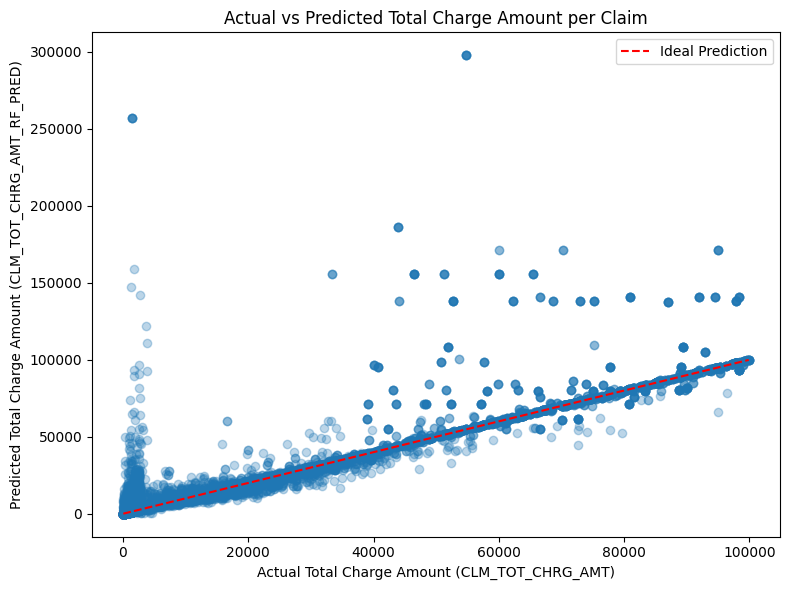

In [32]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(train_df['CLM_TOT_CHRG_AMT'], train_df['CLM_TOT_CHRG_AMT_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Total Charge Amount (CLM_TOT_CHRG_AMT)')
plt.ylabel('Predicted Total Charge Amount (CLM_TOT_CHRG_AMT_RF_PRED)')
plt.title('Actual vs Predicted Total Charge Amount per Claim')
plt.plot([train_df['CLM_TOT_CHRG_AMT'].min(), train_df['CLM_TOT_CHRG_AMT'].max()],
         [train_df['CLM_TOT_CHRG_AMT'].min(), train_df['CLM_TOT_CHRG_AMT'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# check feature importances
import pandas as pd

importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(importance_df)

# THESE DO SEEM A BIT ODD
# prncipal being really important makes sense
# cd1 being less important fits because it is often a copy of principal
# after that I would expect it mostly to be in number order. Why is it not?

                  feature  importance
25  PRNCPAL_DGNS_CD_TMEAN    0.498348
2      ICD_DGNS_CD3_TMEAN    0.118254
13    ICD_DGNS_CD14_TMEAN    0.037224
3      ICD_DGNS_CD4_TMEAN    0.036065
4      ICD_DGNS_CD5_TMEAN    0.033420
7      ICD_DGNS_CD8_TMEAN    0.032783
8      ICD_DGNS_CD9_TMEAN    0.029741
19    ICD_DGNS_CD20_TMEAN    0.029693
0      ICD_DGNS_CD1_TMEAN    0.023832
9     ICD_DGNS_CD10_TMEAN    0.023379
5      ICD_DGNS_CD6_TMEAN    0.023314
6      ICD_DGNS_CD7_TMEAN    0.022600
1      ICD_DGNS_CD2_TMEAN    0.015503
14    ICD_DGNS_CD15_TMEAN    0.014371
11    ICD_DGNS_CD12_TMEAN    0.012202
10    ICD_DGNS_CD11_TMEAN    0.011765
12    ICD_DGNS_CD13_TMEAN    0.010623
15    ICD_DGNS_CD16_TMEAN    0.007401
16    ICD_DGNS_CD17_TMEAN    0.005222
18    ICD_DGNS_CD19_TMEAN    0.004319
17    ICD_DGNS_CD18_TMEAN    0.003801
20    ICD_DGNS_CD21_TMEAN    0.002273
21    ICD_DGNS_CD22_TMEAN    0.002047
22    ICD_DGNS_CD23_TMEAN    0.000957
24    ICD_DGNS_CD25_TMEAN    0.000619
23    ICD_DG

In [16]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

from sklearn.ensemble import IsolationForest
import numpy as np

# Prepare the feature: difference between actual and predicted days
train_diff_days_inpatient = train_df['CLM_TOT_CHRG_AMT'] - train_df['CLM_TOT_CHRG_AMT_RF_PRED']

# Reshape for IsolationForest
train_diff_reshape = train_diff_days_inpatient.values.reshape(-1, 1)

# Fit IsolationForest on the difference
iso_diff = IsolationForest(random_state=42, contamination='auto')
iso_diff.fit(train_diff_reshape)

# Get the decision function scores
train_decision_scores = iso_diff.decision_function(train_diff_reshape)

# Store the scores in the dataframe
train_df['CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE'] = train_decision_scores

In [17]:
train_df[['BENE_ID', 'CLM_ID', 'CLM_TOT_CHRG_AMT', 'CLM_TOT_CHRG_AMT_RF_PRED', 'CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,CLM_TOT_CHRG_AMT_RF_PRED,CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
18907,-10000010264501,-10000930479403,475206.61,256861.177175,-0.352421,Z952
30751,-10000010271384,-10000930775147,54745.99,297690.449779,-0.352421,C3490
18908,-10000010264501,-10000930479403,475206.61,256861.177175,-0.352421,Z952
18906,-10000010264501,-10000930479403,475206.61,256861.177175,-0.352421,Z952
18927,-10000010264501,-10000930479422,1391.31,256861.177175,-0.352421,Z952
...,...,...,...,...,...,...
15772,-10000010262670,-10000930401171,816.76,816.760000,0.201057,Z733
35828,-10000010274268,-10000930912140,8293.27,8293.270000,0.201057,Z7682
49790,-10000010282387,-10000931260498,1323.06,1323.060000,0.201057,T7432X
33352,-10000010272885,-10000930844690,837.86,837.860000,0.201057,J209


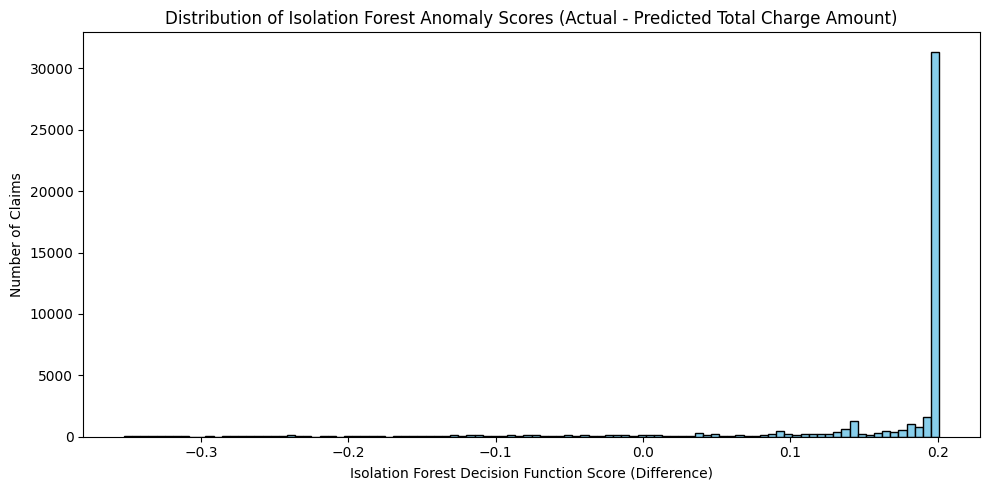

In [18]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(train_df['CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Total Charge Amount)')
plt.tight_layout()
plt.show()

# LETS WORK WITH THE TEST DATA
-------------------
--------------------

In [ ]:
# Exclude any rows with CLM_TOT_CHRG_AMT > 100000 from train_df before encoding and modeling
test_df = test_df[test_df['CLM_TOT_CHRG_AMT'] <= 100000].copy()

In [33]:
# add the principal diagnosis code TMEAN to the test set
test_df['PRNCPAL_DGNS_CD_TMEAN'] = test_df['PRNCPAL_DGNS_CD'].map(principal_code_tmean)

# Map the diagnosis columns to their TMEAN values
for col in diagnosis_cols:
    test_df[f'{col}_TMEAN'] = test_df[col].map(diag_code_Tmeans)

In [20]:
# use the random forest model to predict on the test set


rf_test_data = test_df[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN', 'CLM_TOT_CHRG_AMT']]

X_test = rf_test_data[tmean_cols + ['PRNCPAL_DGNS_CD_TMEAN']]
y_test = rf_test_data['CLM_TOT_CHRG_AMT']

# Predict on the same data and evaluate
y_test_pred = rf.predict(X_test)

# Add predictions to the DataFrame
test_df.loc[rf_test_data.index, 'CLM_TOT_CHRG_AMT_RF_PRED'] = y_test_pred

In [21]:
test_df

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,PRNCPAL_DGNS_CD,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_DGNS_CD17_TMEAN,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_TOT_CHRG_AMT_RF_PRED
12981,-10000010260856,-10000930312741,116.08,T50901A,Z608,Z733,Z951,R931,I259,E1122,...,8359.949597,11674.251246,6532.699963,14973.432427,16475.012672,19683.147567,19294.807352,13987.691035,NaN,123.726300
36647,-10000010274743,-10000930940208,115.63,S060X0,S060X0,S069,Z608,Z733,E669,Z7289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.134400
24652,-10000010267636,-10000930612427,127.17,S63509,S63509,T7431X,N1830,E1121,O039,J329,...,45057.753636,61027.550000,16354.924216,13477.281737,6715.505863,6532.699963,16475.012672,41310.995000,81195.663333,217.181400
35130,-10000010273834,-10000930895135,668.94,N182,N182,M7918,M542,Z604,Y0703,Z940,...,14973.432427,8214.087499,8408.927331,11674.251246,14988.658171,19683.147567,NaN,NaN,NaN,669.972300
25267,-10000010267897,-10000930625863,9555.81,S72009,S72009,T7432X,Z608,Z608,Z653,N1830,...,12442.584560,8144.356186,8359.949597,7565.241074,8593.297837,16475.012672,11368.787803,14973.432427,12037.217370,9255.883800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39942,-10000010276250,-10000931011798,209755.73,J439,Z733,T7432X,J439,E669,G8254,N1830,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73094.304122
54901,-10000010285480,-10000931387823,8218.16,C50919,T7432X,Z733,C50929,E0922,R801,R931,...,8214.087499,8987.050316,8144.356186,11485.690046,11368.787803,11674.251246,14973.432427,14988.658171,13477.281737,15368.527000
51484,-10000010282782,-10000931281831,1568.64,Z608,Z608,Z733,R0902,N1830,R801,M810,...,12037.217370,8214.087499,14988.658171,16475.012672,14973.432427,7473.626889,NaN,NaN,NaN,1561.786100
26538,-10000010268942,-10000930672207,1220.19,Z733,Z733,N181,Z940,R809,R801,E1121,...,14988.658171,16475.012672,14973.432427,10911.882838,NaN,NaN,NaN,NaN,NaN,1145.885100


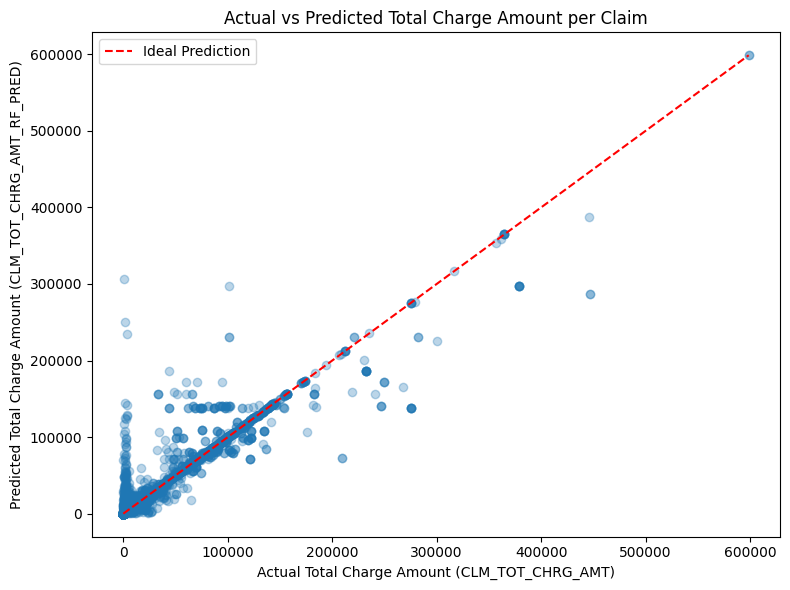

In [22]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(test_df['CLM_TOT_CHRG_AMT'], test_df['CLM_TOT_CHRG_AMT_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Total Charge Amount (CLM_TOT_CHRG_AMT)')
plt.ylabel('Predicted Total Charge Amount (CLM_TOT_CHRG_AMT_RF_PRED)')
plt.title('Actual vs Predicted Total Charge Amount per Claim')
plt.plot([test_df['CLM_TOT_CHRG_AMT'].min(), test_df['CLM_TOT_CHRG_AMT'].max()],
         [test_df['CLM_TOT_CHRG_AMT'].min(), test_df['CLM_TOT_CHRG_AMT'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Now use IsolationForest on the residuals (difference between actual and predicted days)
# if the results is near -1 then it is an outlier

# Prepare the feature: difference between actual and predicted days
test_diff_charge_inpatient = test_df['CLM_TOT_CHRG_AMT'] - test_df['CLM_TOT_CHRG_AMT_RF_PRED']

# Reshape for IsolationForest
test_diff_reshape = test_diff_charge_inpatient.values.reshape(-1, 1)

# Get the decision function scores
test_decision_scores = iso_diff.decision_function(test_diff_reshape)

# Store the scores in the dataframe
test_df['CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE'] = test_decision_scores

In [24]:
test_df[['BENE_ID', 'CLM_ID', 'CLM_TOT_CHRG_AMT', 'CLM_TOT_CHRG_AMT_RF_PRED', 'CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE', 'PRNCPAL_DGNS_CD']].sort_values('CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE', ascending=True)

,BENE_ID,CLM_ID,CLM_TOT_CHRG_AMT,CLM_TOT_CHRG_AMT_RF_PRED,CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE,PRNCPAL_DGNS_CD
4672,-10000010256854,-10000930129855,1196.51,306476.307184,-0.352421,A419
8394,-10000010258576,-10000930213652,1755.94,250155.323497,-0.352421,Z952
43960,-10000010278164,-10000931106805,446797.95,286856.154500,-0.351269,Z952
55068,-10000010285604,-10000931391163,3769.97,234257.233050,-0.351269,Z952
43959,-10000010278164,-10000931106805,446797.95,286856.154500,-0.351269,Z952
...,...,...,...,...,...,...
10406,-10000010259637,-10000930261885,1001.63,1001.630000,0.201057,Z733
47971,-10000010281505,-10000931223115,14827.41,14827.410000,0.201057,Z7682
57881,-10000010287882,-10000931478448,31774.98,31774.980000,0.201057,J1282
45366,-10000010279421,-10000931152744,24990.97,24990.970000,0.201057,J1282


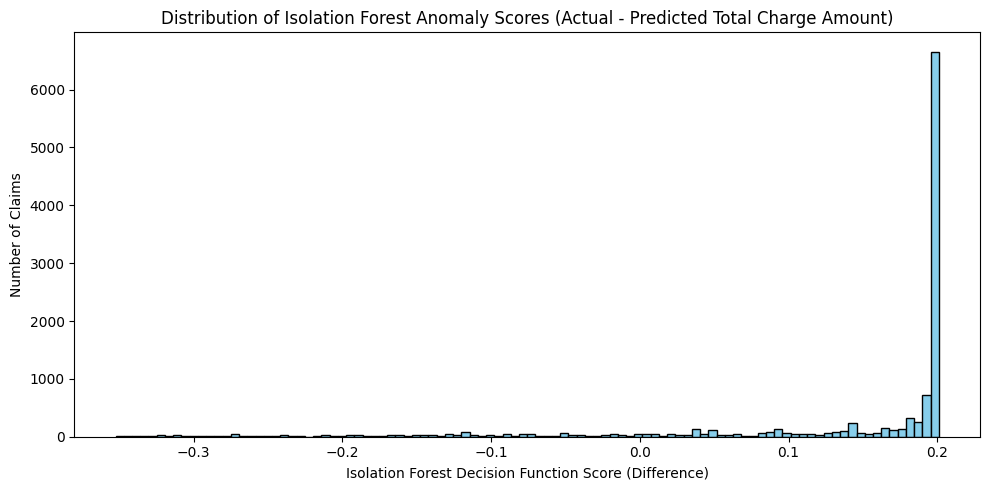

In [25]:
import matplotlib.pyplot as plt

# Visualize the Isolation Forest anomaly scores for the difference between actual and predicted days
plt.figure(figsize=(10, 5))
plt.hist(test_df['CLM_TOT_CHRG_AMT_IFOREST_DIFF_SCORE'], bins=100, color='skyblue', edgecolor='k')
plt.xlabel('Isolation Forest Decision Function Score (Difference)')
plt.ylabel('Number of Claims')
plt.title('Distribution of Isolation Forest Anomaly Scores (Actual - Predicted Total Charge Amount)')
plt.tight_layout()
plt.show()

In [26]:
# Test the prediction accuracy of the random forest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Squared Error: 121006407.626
Root Mean Squared Error: 11000.291
Mean Absolute Error: 2020.021
R^2 Score: 0.894
